In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas as pd
import pywt
import sklearn
import math

path = r'C:\Users\zzsgdsg7\Desktop\2021年B题\附件1 监测点A空气质量预报基础数据.xlsx'

data = pd.read_excel(path,sheet_name=1)
data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
data.set_axis(['time', 'place', 'so2','no2','pm10', 'pm2.5', 'o3','co','temperature', 'humidity', 'pressure','wind','direction'], axis='columns',inplace=True)
#print(data.head())

#数据基本处理
modeltime = data['time']
data = data.drop(columns=['place','time'])
data= data.replace('—', np.nan)
data = data.astype('float')
data[ data< 0 ] = np.nan
print(data.head())
data.insert(0,'time',modeltime)#重新插入时间列

#KNN插值

data_knn =data

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):#判断值是否是空
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

for indexs in data.columns:
    if indexs =='time':
        continue
    data_knn[indexs] = knn_mean(data_knn[indexs].values,24)

   so2   no2  pm10  pm2.5    o3   co  temperature  humidity  pressure  wind  \
0  5.0  75.0  61.0   38.0   1.0  1.0         21.1      89.0    1013.0   1.2   
1  5.0  64.0  60.0   41.0  25.0  0.8         20.4      92.0    1012.4   1.1   
2  4.0  60.0  36.0   40.0  25.0  0.8         20.0      93.0    1011.3   1.1   
3  4.0  39.0  35.0   33.0  41.0  0.7         19.8      93.0    1010.4   1.5   
4  4.0  39.0  28.0   39.0  36.0  0.8         19.9      92.0    1010.0   1.5   

   direction  
0      346.5  
1       18.0  
2       65.9  
3       78.4  
4       73.5  


In [2]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym8', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')



In [3]:
so2 = data_knn['so2']
no2 = data_knn['no2']
pm10 = data_knn['pm10']
pm25 = data_knn['pm2.5']
o3 = data_knn['o3']
co = data_knn['co']
temperature = data_knn['temperature']
humidity = data_knn['humidity']
pressure = data_knn['pressure']
wind = data_knn['wind']
direction = data_knn['direction']

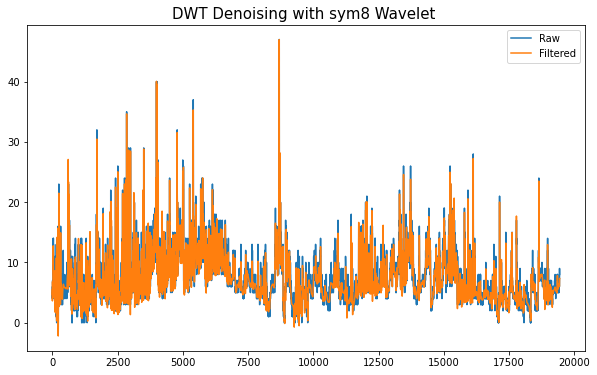

In [4]:
#可视化
wav = 'sym8'
filtered = wavelet_denoising(so2, wavelet = wav, level = 1)
plt.figure(figsize = (10,6))
plt.plot(so2,label = 'Raw')
plt.plot(filtered,label = 'Filtered')
plt.legend()
plt.title(f"DWT Denoising with sym8 Wavelet ",size = 15)
plt.show()

In [5]:
so2_w1 = wavelet_denoising(so2)
no2_w1 = wavelet_denoising(no2)
pm10_w1 = wavelet_denoising(pm10)
pm25_w1 = wavelet_denoising(pm25)
o3_w1 = wavelet_denoising(o3)
co_w1 = wavelet_denoising(co)
temperature_w1 = wavelet_denoising(temperature)
humidity_w1 = wavelet_denoising(humidity)
pressure_w1 = wavelet_denoising(pressure)
wind_w1 = wavelet_denoising(wind)
direction_w1 = wavelet_denoising(direction)

C:\Users\zzsgdsg7\AppData\Local\Temp\ipykernel_21524\2240508160.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


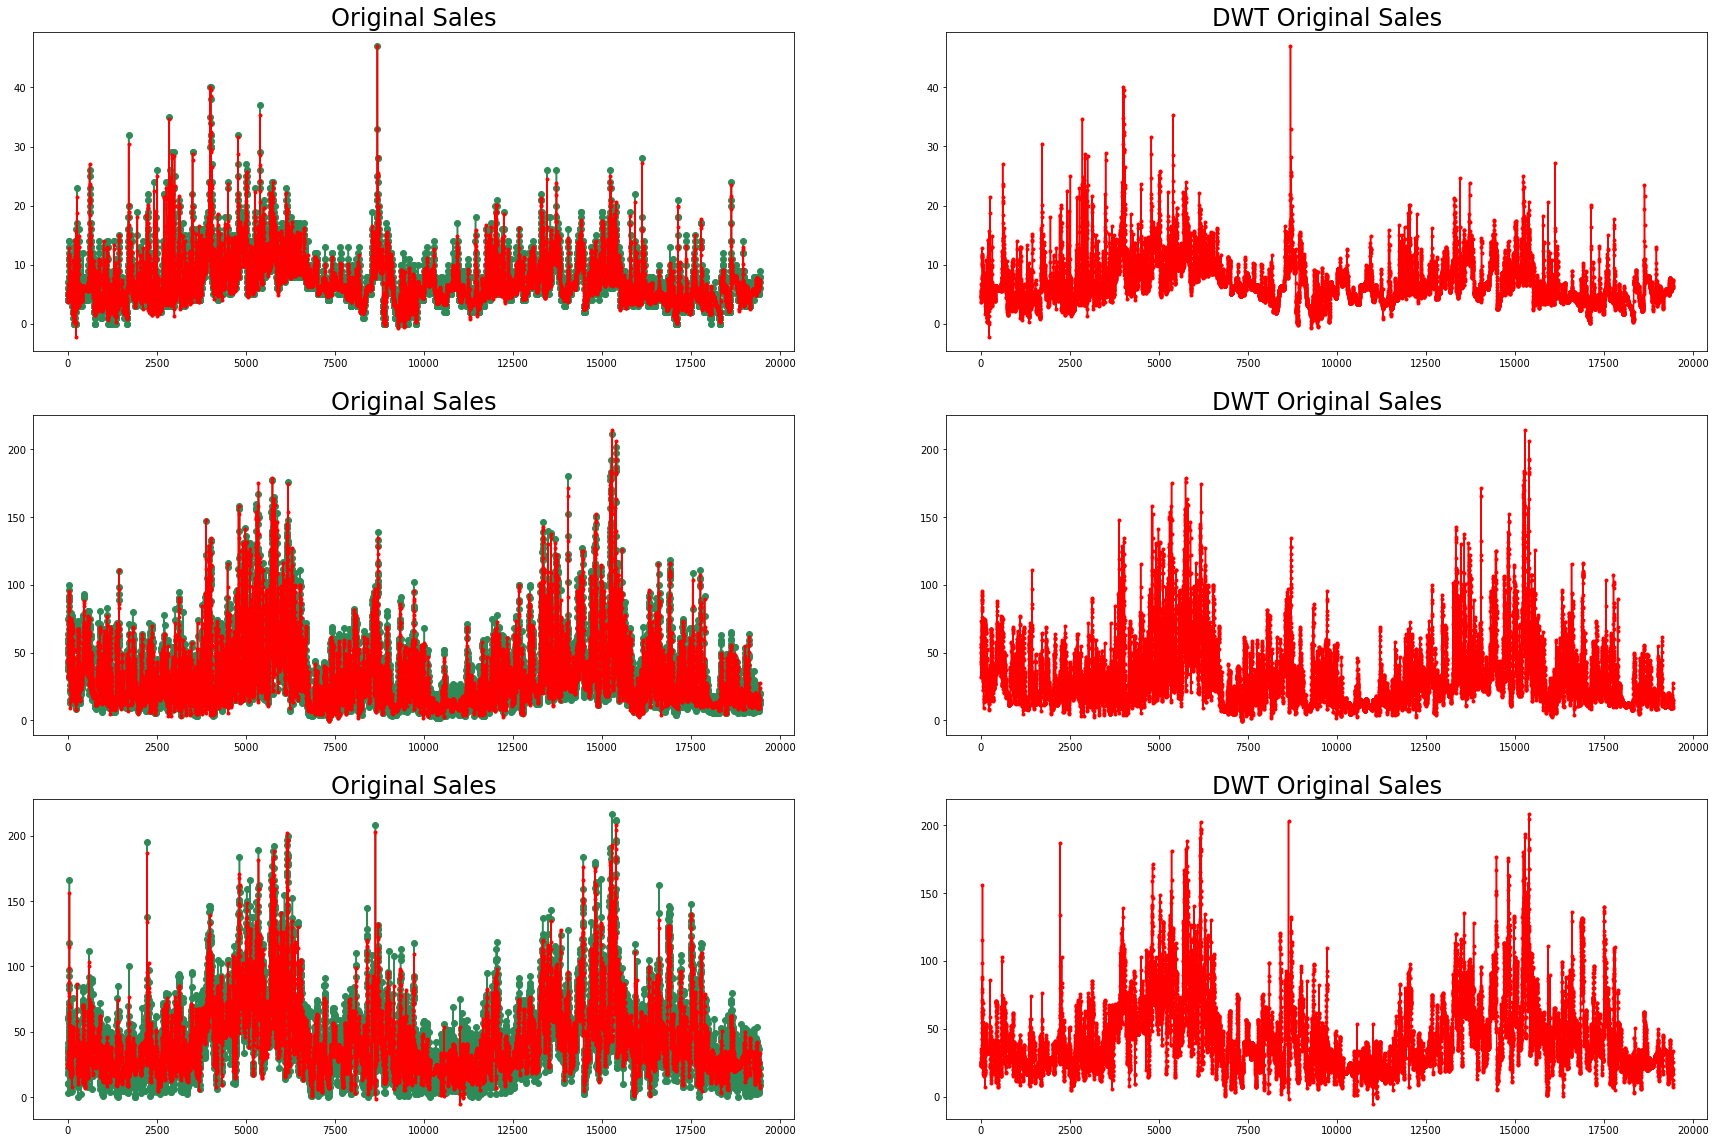

In [6]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(30,20))

ax[0,0].plot(so2,color='seagreen',marker='o')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,0].plot(so2_w1,color='red',marker='.')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,1].plot(so2_w1,color='red',marker='.')
ax[0,1].set_title('DWT Original Sales',fontsize=24)

ax[1,0].plot(no2,color='seagreen',marker='o')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,0].plot(no2_w1,color='red',marker='.')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,1].plot(no2_w1,color='red',marker='.')
ax[1,1].set_title('DWT Original Sales',fontsize=24)

ax[2,0].plot(pm10,color='seagreen',marker='o')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,0].plot(pm10_w1,color='red',marker='.')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,1].plot(pm10_w1,color='red',marker='.')
ax[2,1].set_title('DWT Original Sales',fontsize=24)

fig.show()

In [7]:
#评价指标RMSE
def rsme(data,data_w1):
    MSE = np.square(np.subtract(data,data_w1)).mean()
    rsme = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(rsme)
    

In [8]:
rsme(pm25,pm25_w1)

Root Mean Square Error:

4.30634699718559
